In [13]:
import numpy as np
import csv
import re

In [14]:
# !python -m pip install lyricsgenius
from lyricsgenius import Genius
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds

In [15]:
token = 'M4ryjx_Lsw6ivDYBJDstefp269uJrax2fYcntlBjYDRvH70j0jNrj67xaE8q66M0'
genius = Genius(token, remove_section_headers=True, timeout=20)
genius.remove_section_headers = True

In [16]:
df2 = pd.read_csv('../compiled-w-songs-filtered.csv')
df2 = df2.iloc[551:1074]
artists2 = df2[['Artist', 'Songs']]

In [17]:
artists_songs2 = dict(zip(artists2['Artist'], artists2['Songs']))
for artist in artists_songs2:
    songs = artists_songs2[artist].replace('"', "'").strip("'[]").split("', '")
    artists_songs2[artist] = songs

In [18]:
df2.tail()

,Unnamed: 0,Unnamed: 0.1,Artist,Genres,Followers,Popularity,Songs,Length
1069,2609,2609,Dreamville,"['hip hop', 'rap', 'underground hip hop']",341868,72,['Under The Sun (with J. Cole & Lute feat. DaB...,10
1070,2610,2610,Dreddy Kruger,['wu fam'],347408,61,"[""Shadowboxin'"", '4th Chamber', 'Liquid Swords...",9
1071,2611,2611,Dreezy,"['chicago rap', 'drill', 'hip pop', 'pop r&b',...",576982,60,"['Body', 'Spar (feat. 6LACK & Kodak Black)', '...",10
1072,2615,2615,Drey,"['broadway', 'hollywood', 'show tunes']",6315273,85,"['Dreams - 2004 Remaster', 'The Chain - 2004 R...",10
1073,2618,2618,Dropgun,"['big room', 'deep big room', 'edm', 'electro ...",320673,64,"['When You Leave - Breathe Carolina Remix', 'H...",9


In [19]:
song_lyrics = {}
artists2 = list(artists_songs2)

for artist in artists2:
    song_info = []
    for song in artists_songs2[artist]:
        try:
            song_info.append(genius.search_song(song, artist=artist))
        except Exception as e:
            print(song, artist, e)
    song_lyrics[artist] = song_info

Searching for "Ms. New Booty" by Bubba Sparxxx...
Done.
Searching for "Deliverance" by Bubba Sparxxx...
Done.
Searching for "Outback (Extended Remix)" by Bubba Sparxxx...
Done.
Searching for "Country Folks (feat. Colt Ford & Danny Boone)" by Bubba Sparxxx...
Done.
Searching for "Put in Work" by Bubba Sparxxx...
Done.
Searching for "Country to the City (feat. Jg Made Um Look)" by Bubba Sparxxx...
No results found for: 'Country to the City (feat. Jg Made Um Look) Bubba Sparxxx'
Searching for "Ugly" by Bubba Sparxxx...
Done.
Searching for "Heat It Up" by Bubba Sparxxx...
Done.
Searching for "Ms. New Booty" by Bubba Sparxxx...
Done.
Searching for "Way Down South (feat. Kyle Cook, Danny Boone, and Demun Jones)" by Bubba Sparxxx...
Done.
Searching for "Crazy Bitch" by Buckcherry...
Done.
Searching for "Lit Up" by Buckcherry...
Done.
Searching for "Sorry" by Buckcherry...
Done.
Searching for "Say Fuck It" by Buckcherry...
Done.
Searching for "Crazy Bitch" by Buckcherry...
Done.
Searching for 

Done.
Searching for "Hills And Valleys" by Buju Banton...
Done.
Searching for "Champion" by Buju Banton...
Done.
Searching for "Dangerous City (feat. Buju Banton)" by Buju Banton...
Done.
Searching for "Pressure (feat. Buju Banton) - Remix" by Buju Banton...
Done.
Searching for "Cherry Pie (feat. Pharrell Williams)" by Buju Banton...
Done.
Searching for "Untold Stories" by Buju Banton...
Done.
Searching for "Blessed" by Buju Banton...
Done.
Searching for "Trust" by Buju Banton...
Done.
Searching for "Buried Alive" by Buju Banton...
Done.
Searching for "Yes Mi Friend (feat. Stephen Marley)" by Buju Banton...
Done.
Searching for "Float On" by Buk...
Done.
Searching for "Dashboard" by Buk...
Done.
Searching for "Missed the Boat" by Buk...
Done.
Searching for "Lampshades on Fire" by Buk...
No results found for: 'Lampshades on Fire Buk'
Searching for "The World At Large" by Buk...
Done.
Searching for "Gravity Rides Everything" by Buk...
Done.
Searching for "Ocean Breathes Salty" by Buk...
D

Specified song does not contain lyrics. Rejecting.
Searching for "The Four Seasons - Summer in G Minor, RV. 315: III. Presto" by Béla Drahos...
No results found for: 'The Four Seasons - Summer in G Minor, RV. 315: III. Presto Béla Drahos'
Searching for "Vivaldi: Violin Concerto in G Minor, RV 315 'L\'estate' (No. 2 from 'Il cimento dell\'armonia e dell\'inventione', Op. 8): III. Presto" by Béla Drahos...
No results found for: 'Vivaldi: Violin Concerto in G Minor, RV 315 'L\'estate' (No. 2 from 'Il cimento dell\'armonia e dell\'inventione', Op. 8): III. Presto Béla Drahos'
Searching for "The Four Seasons - Winter in F Minor, RV. 297: I. Allegro non molto" by Béla Drahos...
No results found for: 'The Four Seasons - Winter in F Minor, RV. 297: I. Allegro non molto Béla Drahos'
Searching for "Concerto for Lute, 2 Violins and Continuo in D major, RV 93: 2. Largo (Arr. for Guitar)" by Béla Drahos...
No results found for: 'Concerto for Lute, 2 Violins and Continuo in D major, RV 93: 2. Largo 

Done.
Searching for "positions" by C.C.Grand...
Done.
Searching for "34+35" by C.C.Grand...
Done.
Searching for "7 rings" by C.C.Grand...
No results found for: '7 rings C.C.Grand'
Searching for "Stuck with U (with Justin Bieber)" by C.C.Grand...
No results found for: 'Stuck with U (with Justin Bieber) C.C.Grand'
Searching for "thank u, next" by C.C.Grand...
No results found for: 'thank u, next C.C.Grand'
Searching for "Rain On Me (with Ariana Grande)" by C.C.Grand...
No results found for: 'Rain On Me (with Ariana Grande) C.C.Grand'
Searching for "pov" by C.C.Grand...
No results found for: 'pov C.C.Grand'
Searching for "34+35 Remix (feat. Doja Cat, Megan Thee Stallion) - Remix" by C.C.Grand...
No results found for: '34+35 Remix (feat. Doja Cat, Megan Thee Stallion) - Remix C.C.Grand'
Searching for "motive (with Doja Cat)" by C.C.Grand...
No results found for: 'motive (with Doja Cat) C.C.Grand'
Searching for "God is a woman" by C.C.Grand...
No results found for: 'God is a woman C.C.Grand

Done.
Searching for "Honey Boo" by CNCO...
Done.
Searching for "Me Necesita" by CNCO...
Done.
Searching for "Por Amarte Así" by CNCO...
Done.
Searching for "Amor Narcótico" by CNCO...
Done.
Searching for "LILAC" by COIN...
Done.
Searching for "Celebrity" by COIN...
Done.
Searching for "eight(Prod.&Feat. SUGA of BTS)" by COIN...
Done.
Searching for "Coin" by COIN...
Done.
Searching for "Blueming" by COIN...
Done.
Searching for "BBIBBI" by COIN...
Done.
Searching for "Flu" by COIN...
Done.
Searching for "Troll (Feat. DEAN)" by COIN...
Done.
Searching for "Palette (feat. G-DRAGON)" by COIN...
No results found for: 'Palette (feat. G-DRAGON) COIN'
Searching for "My sea" by COIN...
Done.
Searching for "Hallucinogenics" by CRi...
Done.
Searching for "Cringe" by CRi...
Done.
Searching for "Hallucinogenics (feat. Lana Del Rey)" by CRi...
No results found for: 'Hallucinogenics (feat. Lana Del Rey) CRi'
Searching for "Put It on Me" by CRi...
Done.
Searching for "Go Easy" by CRi...
Done.
Searching

Done.
Searching for "Corrido De Juanito" by Calibre 50...
Done.
Searching for "Rebels" by Call Me Karizma...
Done.
Searching for "F U Till I F U" by Call Me Karizma...
Done.
Searching for "Art Hoe" by Call Me Karizma...
Done.
Searching for "Serotonin" by Call Me Karizma...
Done.
Searching for "Rockstar" by Call Me Karizma...
Done.
Searching for "Monster (Under My Bed)" by Call Me Karizma...
Done.
Searching for "Float" by Call Me Karizma...
Done.
Searching for "God Damnit (with Call Me Karizma)" by Call Me Karizma...
Done.
Searching for "Frank Ocean" by Call Me Karizma...
Done.
Searching for "Nails" by Call Me Karizma...
Done.
Searching for "Atrévete-Te-Te" by Calle 13...
Done.
Searching for "Muerte En Hawaii" by Calle 13...
Done.
Searching for "Ojos Color Sol (feat. Silvio Rodríguez)" by Calle 13...
Done.
Searching for "La Vuelta Al Mundo" by Calle 13...
Done.
Searching for "Latinoamérica (feat. Totó la Momposina, Susana Baca & Maria Rita)" by Calle 13...
Done.
Searching for "No Hay Na

No results found for: 'Requiem in D Minor, K. 626: Sequence: VI. Lacrimosa dies illa Camerata Academica des Mozarteums Salzburg'
Searching for "Symphony No. 40 in G Minor, K. 550: I. Molto allegro" by Camerata Academica des Mozarteums Salzburg...
No results found for: 'Symphony No. 40 in G Minor, K. 550: I. Molto allegro Camerata Academica des Mozarteums Salzburg'
Searching for "Mozart: Clarinet Concerto in A Major, K. 622: II. Adagio" by Camerata Academica des Mozarteums Salzburg...
No results found for: 'Mozart: Clarinet Concerto in A Major, K. 622: II. Adagio Camerata Academica des Mozarteums Salzburg'
Searching for "Señorita" by Camila...
Done.
Searching for "Havana (feat. Young Thug)" by Camila...
Done.
Searching for "My Oh My (feat. DaBaby)" by Camila...
Done.
Searching for "South of the Border (feat. Camila Cabello & Cardi B)" by Camila...
Done.
Searching for "Beautiful (feat. Camila Cabello)" by Camila...
Done.
Searching for "Bad Things (with Camila Cabello)" by Camila...
Done.

Done.
Searching for "The Masquerade Is Over" by Cannonball Adderley...
Done.
Searching for "One For Daddy-O - Remastered" by Cannonball Adderley...
No results found for: 'One For Daddy-O - Remastered Cannonball Adderley'
Searching for "Never Will I Marry" by Cannonball Adderley...
Done.
Searching for "Autumn Leaves" by Cannonball Adderley...
Specified song does not contain lyrics. Rejecting.
Searching for "Dancing In The Dark" by Cannonball Adderley...
Done.
Searching for "Love For Sale - Remastered" by Cannonball Adderley...
No results found for: 'Love For Sale - Remastered Cannonball Adderley'
Searching for "Save Your Love For Me" by Cannonball Adderley...
Done.
Searching for "Waltz For Debby" by Cannonball Adderley...
Specified song does not contain lyrics. Rejecting.
Searching for "Somethin' Else - Remastered" by Cannonball Adderley...
No results found for: 'Somethin' Else - Remastered Cannonball Adderley'
Searching for "Fire for You" by Cannons...
Done.
Searching for "Bad Dream" b

Done.
Searching for "Cry Baby (feat. DaBaby)" by Captain Hook...
No results found for: 'Cry Baby (feat. DaBaby) Captain Hook'
Searching for "Savage" by Captain Hook...
Done.
Searching for "Savage Remix (feat. Beyoncé)" by Captain Hook...
No results found for: 'Savage Remix (feat. Beyoncé) Captain Hook'
Searching for "Girls in the Hood" by Captain Hook...
Done.
Searching for "Captain Hook" by Captain Hook...
Done.
Searching for "Cash Shit (feat. DaBaby)" by Captain Hook...
No results found for: 'Cash Shit (feat. DaBaby) Captain Hook'
Searching for "Hot Girl Summer (feat. Nicki Minaj & Ty Dolla $ign)" by Captain Hook...
No results found for: 'Hot Girl Summer (feat. Nicki Minaj & Ty Dolla $ign) Captain Hook'
Searching for "Brown Eyed Girl" by Caravan...
Done.
Searching for "Into the Mystic - 2013 Remaster" by Caravan...
No results found for: 'Into the Mystic - 2013 Remaster Caravan'
Searching for "Moondance - 2013 Remaster" by Caravan...
No results found for: 'Moondance - 2013 Remaster Ca

Done.
Searching for "Stand By Your Man" by Carla Bruni...
Done.
Searching for "Miss You" by Carla Bruni...
Done.
Searching for "Quelque chose" by Carla Bruni...
Done.
Searching for "Raphael" by Carla Bruni...
Done.
Searching for "Un grand amour" by Carla Bruni...
Done.
Searching for "Miss You - Nouvelle Vague Remix" by Carla Bruni...
No results found for: 'Miss You - Nouvelle Vague Remix Carla Bruni'
Searching for "Disfruto" by Carla Morrison...
Done.
Searching for "Te Regalo" by Carla Morrison...
Done.
Searching for "Eres Tú" by Carla Morrison...
Done.
Searching for "Disfruto - Audioiko Remix" by Carla Morrison...
Done.
Searching for "Recuerdo" by Carla Morrison...
Done.
Searching for "Déjenme Llorar" by Carla Morrison...
Done.
Searching for "No Me Llames" by Carla Morrison...
Done.
Searching for "Hasta la Piel" by Carla Morrison...
Done.
Searching for "Todo Pasa" by Carla Morrison...
Done.
Searching for "Compartir" by Carla Morrison...
Done.
Searching for "Robarte un Beso" by Carlo..

No results found for: 'Suite bergamasque, L. 75: 3. Clair de lune Carol Comune'
Searching for "Suite bergamasque, L. 75: Clair de lune" by Carol Comune...
No results found for: 'Suite bergamasque, L. 75: Clair de lune Carol Comune'
Searching for "Rêverie, L. 68: Rêverie" by Carol Comune...
No results found for: 'Rêverie, L. 68: Rêverie Carol Comune'
Searching for "Préludes / Book 2, L. 123: 5. Bruyères - Home Session" by Carol Comune...
No results found for: 'Préludes / Book 2, L. 123: 5. Bruyères - Home Session Carol Comune'
Searching for "Dances for Harp and Orchestra, L. 103: 2. Danse profane" by Carol Comune...
No results found for: 'Dances for Harp and Orchestra, L. 103: 2. Danse profane Carol Comune'
Searching for "2 Arabesques, L. 66: No. 1 in E Major" by Carol Comune...
No results found for: '2 Arabesques, L. 66: No. 1 in E Major Carol Comune'
Searching for "Debussy : Suite bergamasque : III Clair de lune" by Carol Comune...
No results found for: 'Debussy : Suite bergamasque : 

Done.
Searching for "Anti-Sea Shanty" by Cartoons...
No results found for: 'Anti-Sea Shanty Cartoons'
Searching for "Everytime We Touch" by Cascada...
Done.
Searching for "Everytime We Touch - Hardwell & Maurice West Remix" by Cascada...
Done.
Searching for "Evacuate The Dancefloor - Radio Edit" by Cascada...
Done.
Searching for "Everytime We Touch - Sound Rush Remix" by Cascada...
Done.
Searching for "Everytime We Touch - Fallen Superhero Remix" by Cascada...
No results found for: 'Everytime We Touch - Fallen Superhero Remix Cascada'
Searching for "Bad Boy" by Cascada...
Done.
Searching for "Everytime We Touch - B3nte Remix" by Cascada...
Done.
Searching for "Because the Night" by Cascada...
Done.
Searching for "Truly Madly Deeply - Radio Edit" by Cascada...
Done.
Searching for "Everytime We Touch - Yanou's Candlelight Mix" by Cascada...
Done.
Searching for "Case Closed" by Case...
Done.
Searching for "Penguins" by Case...
Done.
Searching for "On the River" by Case...
Done.
Searching 

No results found for: 'Vivaldi Variation (Arr. for Piano from Concerto for Strings in G Minor, RV 156) Catherine Wyn-Rogers'
Searching for "The Four Seasons - Violin Concerto in F Minor, Op. 8 No. 4, RV 297 'Winter': I. Allegro non molto" by Catherine Wyn-Rogers...
Specified song does not contain lyrics. Rejecting.
Searching for "The Four Seasons - Summer in G Minor, RV. 315: III. Presto" by Catherine Wyn-Rogers...
No results found for: 'The Four Seasons - Summer in G Minor, RV. 315: III. Presto Catherine Wyn-Rogers'
Searching for "Vivaldi: Violin Concerto in G Minor, RV 315 'L\'estate' (No. 2 from 'Il cimento dell\'armonia e dell\'inventione', Op. 8): III. Presto" by Catherine Wyn-Rogers...
No results found for: 'Vivaldi: Violin Concerto in G Minor, RV 315 'L\'estate' (No. 2 from 'Il cimento dell\'armonia e dell\'inventione', Op. 8): III. Presto Catherine Wyn-Rogers'
Searching for "The Four Seasons - Winter in F Minor, RV. 297: I. Allegro non molto" by Catherine Wyn-Rogers...
No resul

No results found for: 'Concerto For 2 Mandolins, Strings And Continuo In G, RV 532: 3. Allegro Cecilia Bartoli'
Searching for "Vivaldi: Violin Concerto in E Major, RV 269, No. 1, Spring: I. Allegro" by Cecilia Bartoli...
No results found for: 'Vivaldi: Violin Concerto in E Major, RV 269, No. 1, Spring: I. Allegro Cecilia Bartoli'
Searching for "Vivaldi: The Four Seasons, Violin Concerto in G Minor, Op. 8 No. 2, RV 315 'Summer': III. Presto" by Cecilia Bartoli...
No results found for: 'Vivaldi: The Four Seasons, Violin Concerto in G Minor, Op. 8 No. 2, RV 315 'Summer': III. Presto Cecilia Bartoli'
Searching for "Nulla in mundo pax, RV 630: 1. Nulla in mundo pax" by Cecilia Bartoli...
No results found for: 'Nulla in mundo pax, RV 630: 1. Nulla in mundo pax Cecilia Bartoli'
Searching for "Fuck You" by CeeLo Green...
Done.
Searching for "Forget You" by CeeLo Green...
Done.
Searching for "Kung Fu Fighting" by CeeLo Green...
Done.
Searching for "Loaded Bases (feat. CeeLo Green)" by CeeLo Gre

Done.
Searching for "Sure on This Shining Night" by Chamber Choir...
Done.
Searching for "Lux aeterna: O Nata Lux" by Chamber Choir...
No results found for: 'Lux aeterna: O Nata Lux Chamber Choir'
Searching for "Les Chansons des roses: No. 5. Dirait-on" by Chamber Choir...
No results found for: 'Les Chansons des roses: No. 5. Dirait-on Chamber Choir'
Searching for "Lux aeterna: Lux Aeterna: O nata lux" by Chamber Choir...
No results found for: 'Lux aeterna: Lux Aeterna: O nata lux Chamber Choir'
Searching for "O Magnum Mysterium" by Chamber Choir...
Done.
Searching for "O Nata Lux" by Chamber Choir...
No results found for: 'O Nata Lux Chamber Choir'
Searching for "O Magnum Mysterium" by Chamber Choir...
Done.
Searching for "O Nata Lux" by Chamber Choir...
No results found for: 'O Nata Lux Chamber Choir'
Searching for "Les Chansons des roses: No. 4. La Rose Complete. No. 5. Dirait-on" by Chamber Choir...
No results found for: 'Les Chansons des roses: No. 4. La Rose Complete. No. 5. Dira

Done.
Searching for "Go Hard or Go Home" by Charli XCX...
Done.
Searching for "Team" by Charli XCX...
Done.
Searching for "Pretty Girls" by Charli XCX...
Done.
Searching for "I Don't Wanna Be Okay Without You" by Charlie Burg...
Done.
Searching for "Lancaster Nights" by Charlie Burg...
Done.
Searching for "Lovesong (The Way) [feat. Bluets]" by Charlie Burg...
Done.
Searching for "Bookstore Girl" by Charlie Burg...
Done.
Searching for "Channel Orange In Your Living Room" by Charlie Burg...
Done.
Searching for "Instead of My Room" by Charlie Burg...
Done.
Searching for "PlantedInMyMind.Memo" by Charlie Burg...
Done.
Searching for "Letter From Last Summer" by Charlie Burg...
Done.
Searching for "June" by Charlie Burg...
Done.
Searching for "Intentions" by Charlie Burg...
Done.
Searching for "The Girl From Ipanema" by Charlie Byrd...
Done.
Searching for "Corcovado (Quiet Nights Of Quiet Stars)" by Charlie Byrd...
No results found for: 'Corcovado (Quiet Nights Of Quiet Stars) Charlie Byrd'


Done.
Searching for "Little Something" by Cheb Mami...
Done.
Searching for "If I Ever Lose My Faith In You" by Cheb Mami...
Done.
Searching for "Reste" by Cheb Mami...
Done.
Searching for "Morning Is Coming (with Shaggy)" by Cheb Mami...
Done.
Searching for "Englishman / African in New York (with Shirazee)" by Cheb Mami...
No results found for: 'Englishman / African in New York (with Shirazee) Cheb Mami'
Searching for "Baila Conmigo (with Rauw Alejandro)" by Chencho Corleone...
No results found for: 'Baila Conmigo (with Rauw Alejandro) Chencho Corleone'
Searching for "La Nota" by Chencho Corleone...
Done.
Searching for "Reloj" by Chencho Corleone...
No results found for: 'Reloj Chencho Corleone'
Searching for "La Curiosidad (feat. Dj Nelson, Jhay Cortez, Lunay & Kendo Kaponi) - Blue Grand Prix Remix" by Chencho Corleone...
No results found for: 'La Curiosidad (feat. Dj Nelson, Jhay Cortez, Lunay & Kendo Kaponi) - Blue Grand Prix Remix Chencho Corleone'
Searching for "Tattoo - Remix wit

No results found for: 'Da Taça / Onde Estará o Meu Amor / Diana - Ao Vivo Chico César'
Searching for "Redbone" by Childish Gambino...
Done.
Searching for "3005" by Childish Gambino...
Done.
Searching for "Feels Like Summer" by Childish Gambino...
Done.
Searching for "This Is America" by Childish Gambino...
Done.
Searching for "Sober" by Childish Gambino...
Done.
Searching for "Bonfire" by Childish Gambino...
Done.
Searching for "IV. Sweatpants" by Childish Gambino...
Done.
Searching for "Summertime Magic" by Childish Gambino...
Done.
Searching for "Hakuna Matata" by Childish Gambino...
No results found for: 'Hakuna Matata Childish Gambino'
Searching for "Heartbeat" by Childish Gambino...
Done.
Searching for "Are You Dead Yet" by Children Of Bodom...
Done.
Searching for "Downfall" by Children Of Bodom...
Done.
Searching for "In Your Face" by Children Of Bodom...
Done.
Searching for "Needled 24 / 7" by Children Of Bodom...
Done.
Searching for "I´m Shipping Up To Boston" by Children Of Bo

No results found for: 'Fantasia in D Minor, K.397 Chor der St. Hedwigs-Kathedrale Berlin'
Searching for "Requiem, K. 626: Lacrimosa" by Chor der St. Hedwigs-Kathedrale Berlin...
No results found for: 'Requiem, K. 626: Lacrimosa Chor der St. Hedwigs-Kathedrale Berlin'
Searching for "Symphony No.25 in G minor, K.183: 1. Allegro con brio" by Chor der St. Hedwigs-Kathedrale Berlin...
No results found for: 'Symphony No.25 in G minor, K.183: 1. Allegro con brio Chor der St. Hedwigs-Kathedrale Berlin'
Searching for "Piano Sonata No. 16 in C Major, K. 545 'Sonata facile': 1. Allegro" by Chor der St. Hedwigs-Kathedrale Berlin...
No results found for: 'Piano Sonata No. 16 in C Major, K. 545 'Sonata facile': 1. Allegro Chor der St. Hedwigs-Kathedrale Berlin'
Searching for "Adagio in E Major, K. 261" by Chor der St. Hedwigs-Kathedrale Berlin...
No results found for: 'Adagio in E Major, K. 261 Chor der St. Hedwigs-Kathedrale Berlin'
Searching for "Serenade No. 13 in G Major, K. 525 'Eine kleine Nac

Done.
Searching for "The Secret Place - Acoustic" by Chris Quilala...
No results found for: 'The Secret Place - Acoustic Chris Quilala'
Searching for "Your Love Awakens Me" by Chris Quilala...
Done.
Searching for "Messiah / You're Beautiful" by Chris Quilala...
No results found for: 'Messiah / You're Beautiful Chris Quilala'
Searching for "Loco Contigo (feat. J. Balvin & Tyga)" by Chris Richardson...
No results found for: 'Loco Contigo (feat. J. Balvin & Tyga) Chris Richardson'
Searching for "Still Be Friends (feat. Tory Lanez & Tyga)" by Chris Richardson...
No results found for: 'Still Be Friends (feat. Tory Lanez & Tyga) Chris Richardson'
Searching for "Taste (feat. Offset)" by Chris Richardson...
No results found for: 'Taste (feat. Offset) Chris Richardson'
Searching for "Ayy Macarena" by Chris Richardson...
No results found for: 'Ayy Macarena Chris Richardson'
Searching for "Chosen (feat. Ty Dolla $ign)" by Chris Richardson...
No results found for: 'Chosen (feat. Ty Dolla $ign) Chr

Done.
Searching for "Boulevard of Broken Dreams" by Christie...
Done.
Searching for "When I Come Around" by Christie...
Done.
Searching for "Holiday / Boulevard of Broken Dreams" by Christie...
Done.
Searching for "Brain Stew" by Christie...
Done.
Searching for "Holiday" by Christie...
Done.
Searching for "you'll be ok" by Christina Novelli...
Done.
Searching for "Laserface 01 (Aperture)" by Christina Novelli...
No results found for: 'Laserface 01 (Aperture) Christina Novelli'
Searching for "Take Everything" by Christina Novelli...
Done.
Searching for "Saving Light" by Christina Novelli...
Done.
Searching for "Yesterday" by Christina Novelli...
Done.
Searching for "elise" by Christina Novelli...
Done.
Searching for "Somebody" by Christina Novelli...
Done.
Searching for "Concrete Angel (Radio Edit) (feat. Christina Novelli)" by Christina Novelli...
Done.
Searching for "Never Before" by Christina Novelli...
Done.
Searching for "Reckless" by Christina Novelli...
Done.
Searching for "A Tho

No results found for: 'No Longer Slaves (Spontaneous) - Live Chromagain'
Searching for "God of Revival - Live" by Chromagain...
No results found for: 'God of Revival - Live Chromagain'
Searching for "Champion - Live" by Chromagain...
No results found for: 'Champion - Live Chromagain'
Searching for "Raise a Hallelujah (Studio Version)" by Chromagain...
No results found for: 'Raise a Hallelujah (Studio Version) Chromagain'
Searching for "Stand In Your Love (Radio Version)" by Chromagain...
No results found for: 'Stand In Your Love (Radio Version) Chromagain'
Searching for "Egypt - Live" by Chromagain...
No results found for: 'Egypt - Live Chromagain'
Searching for "Eternal Light" by Chronixx...
Done.
Searching for "Time" by Chronixx...
Done.
Searching for "Beauty & Essex" by Chronixx...
Done.
Searching for "On Sight" by Chronixx...
Done.
Searching for "Gidget" by Chronixx...
Done.
Searching for "Shibuya" by Chronixx...
Done.
Searching for "Apartment" by Chronixx...
Done.
Searching for "T

No results found for: 'Wind Quintet in E-Flat Major, WoO 208, Hess 19: II. Adagio maestoso Cincinnati Pops Orchestra'
Searching for "Piano Sonata No. 8 in C minor, Op. 13, 'Pathétique': II. Adagio cantabile" by Cincinnati Pops Orchestra...
No results found for: 'Piano Sonata No. 8 in C minor, Op. 13, 'Pathétique': II. Adagio cantabile Cincinnati Pops Orchestra'
Searching for "The Spins" by Cinderella...
Done.
Searching for "Self Care" by Cinderella...
Done.
Searching for "Good News" by Cinderella...
Done.
Searching for "Weekend (feat. Miguel)" by Cinderella...
Done.
Searching for "Blue World" by Cinderella...
Done.
Searching for "Dang! (feat. Anderson .Paak)" by Cinderella...
Done.
Searching for "Come Back to Earth" by Cinderella...
Done.
Searching for "My Favorite Part" by Cinderella...
Done.
Searching for "Ladders" by Cinderella...
Done.
Searching for "Small Worlds" by Cinderella...
Done.
Searching for "Baby Blue (feat. Chance the Rapper)" by Cirque du Soleil...
No results found for:

No results found for: 'Dances for Harp and Orchestra, L. 103: 2. Danse profane Claude Debussy'
Searching for "2 Arabesques, L. 66: No. 1 in E Major" by Claude Debussy...
No results found for: '2 Arabesques, L. 66: No. 1 in E Major Claude Debussy'
Searching for "Debussy : Suite bergamasque : III Clair de lune" by Claude Debussy...
Specified song does not contain lyrics. Rejecting.
Searching for "Give Me Everything (feat. Ne-Yo, Afrojack & Nayer)" by Claudia Leitte...
No results found for: 'Give Me Everything (feat. Ne-Yo, Afrojack & Nayer) Claudia Leitte'
Searching for "Time of Our Lives" by Claudia Leitte...
Done.
Searching for "Timber (feat. Ke$ha)" by Claudia Leitte...
No results found for: 'Timber (feat. Ke$ha) Claudia Leitte'
Searching for "International Love (feat. Chris Brown)" by Claudia Leitte...
No results found for: 'International Love (feat. Chris Brown) Claudia Leitte'
Searching for "Feel This Moment (feat. Christina Aguilera)" by Claudia Leitte...
No results found for: 'Fe

Done.
Searching for "Solo (feat. Demi Lovato)" by Clean Bandit...
Done.
Searching for "Rather Be (feat. Jess Glynne)" by Clean Bandit...
Done.
Searching for "I Miss You (feat. Julia Michaels)" by Clean Bandit...
Done.
Searching for "The Business, Pt. II - Clean Bandit Remix" by Clean Bandit...
Done.
Searching for "Real Love x Sunchyme (feat. Jess Glynne) [VIP Mash-up]" by Clean Bandit...
Done.
Searching for "Baby (feat. MARINA & Luis Fonsi)" by Clean Bandit...
Done.
Searching for "Lucid Dreams" by Clever...
Done.
Searching for "Wishing Well" by Clever...
Done.
Searching for "Robbery" by Clever...
Done.
Searching for "All Girls Are The Same" by Clever...
Done.
Searching for "Come & Go (with Marshmello)" by Clever...
Done.
Searching for "Bad Boy (with Young Thug)" by Clever...
Done.
Searching for "Bandit (with YoungBoy Never Broke Again)" by Clever...
Done.
Searching for "Righteous" by Clever...
Done.
Searching for "Hate The Other Side (with Marshmello & The Kid Laroi)" by Clever...
Done

Specified song does not contain lyrics. Rejecting.
Searching for "willow" by Colbie Caillat...
No results found for: 'willow Colbie Caillat'
Searching for "You All Over Me (feat. Maren Morris) (Taylor’s Version) (From The Vault)" by Colbie Caillat...
No results found for: 'You All Over Me (feat. Maren Morris) (Taylor’s Version) (From The Vault) Colbie Caillat'
Searching for "cardigan" by Colbie Caillat...
No results found for: 'cardigan Colbie Caillat'
Searching for "Mr. Perfectly Fine (Taylor’s Version) (From The Vault)" by Colbie Caillat...
No results found for: 'Mr. Perfectly Fine (Taylor’s Version) (From The Vault) Colbie Caillat'
Searching for "champagne problems" by Colbie Caillat...
No results found for: 'champagne problems Colbie Caillat'
Searching for "exile (feat. Bon Iver)" by Colbie Caillat...
No results found for: 'exile (feat. Bon Iver) Colbie Caillat'
Searching for "Blank Space" by Colbie Caillat...
Done.
Searching for "You Need To Calm Down" by Colbie Caillat...
No resu

No results found for: 'Requiem in D Minor, K. 626: Sequence: VI. Lacrimosa dies illa Cologne Chamber Orchestra'
Searching for "Symphony No. 40 in G Minor, K. 550: I. Molto allegro" by Cologne Chamber Orchestra...
Specified song does not contain lyrics. Rejecting.
Searching for "Mozart: Clarinet Concerto in A Major, K. 622: II. Adagio" by Cologne Chamber Orchestra...
No results found for: 'Mozart: Clarinet Concerto in A Major, K. 622: II. Adagio Cologne Chamber Orchestra'
Searching for "Sechs Klavierstücke, Op. 118: II. Intermezzo in A Major" by Cologne Radio Symphony Orchestra...
No results found for: 'Sechs Klavierstücke, Op. 118: II. Intermezzo in A Major Cologne Radio Symphony Orchestra'
Searching for "Hungarian Dance No. 5 in G Minor, WoO 1 No. 5 (Orch. Schmeling)" by Cologne Radio Symphony Orchestra...
No results found for: 'Hungarian Dance No. 5 in G Minor, WoO 1 No. 5 (Orch. Schmeling) Cologne Radio Symphony Orchestra'
Searching for "Wiegenlied, Op. 49, No. 4 (Arr. for Cello and

Done.
Searching for "Coco (feat. DaBaby)" by Company...
Done.
Searching for "VALENTINO" by Company...
Done.
Searching for "Company (feat. Future)" by Company...
Done.
Searching for "3, 2, 1" by Company...
Done.
Searching for "Tinted Eyes (feat. blackbear & 24kGoldn)" by Company...
Done.
Searching for "Love Or Lust" by Company...
Done.
Searching for "Peaches (feat. Daniel Caesar & Giveon)" by Company B...
Done.
Searching for "Hold On" by Company B...
Done.
Searching for "Anyone" by Company B...
Done.
Searching for "Holy (feat. Chance The Rapper)" by Company B...
Done.
Searching for "Lonely (with benny blanco)" by Company B...
Done.
Searching for "Stuck with U (with Justin Bieber)" by Company B...
Done.
Searching for "Monster (Shawn Mendes & Justin Bieber)" by Company B...
Done.
Searching for "10,000 Hours (with Justin Bieber)" by Company B...
Done.
Searching for "As I Am (feat. Khalid)" by Company B...
Done.
Searching for "Unstable (feat. The Kid LAROI)" by Company B...
Done.
Searching 

Done.
Searching for "Tumble’s Lullaby" by Cooper...
Done.
Searching for "Old Skool" by Copyright...
Done.
Searching for "Lost Love" by Copyright...
Done.
Searching for "Majha Block" by Copyright...
No results found for: 'Majha Block Copyright'
Searching for "Copyright" by Copyright...
Done.
Searching for "Prahune" by Copyright...
No results found for: 'Prahune Copyright'
Searching for "Just A Dream" by Copyright...
Done.
Searching for "Jatt Hunde Aa" by Copyright...
No results found for: 'Jatt Hunde Aa Copyright'
Searching for "Liv In" by Copyright...
Done.
Searching for "Boot Cut" by Copyright...
Done.
Searching for "Badmashi" by Copyright...
No results found for: 'Badmashi Copyright'
Searching for "Ayer Me Llamó Mi Ex – Remix" by Corazón...
Done.
Searching for "Carita de Inocente (feat. Myke Towers) - Remix" by Corazón...
No results found for: 'Carita de Inocente (feat. Myke Towers) - Remix Corazón'
Searching for "ANTES QUE SALGA EL SOL" by Corazón...
Done.
Searching for "Corazon Sin

Done.
Searching for "Picture (feat. Sheryl Crow)" by Cowboy...
No results found for: 'Picture (feat. Sheryl Crow) Cowboy'
Searching for "Bawitdaba" by Cowboy...
Done.
Searching for "Cowboy" by Cowboy...
Done.
Searching for "Only God Knows Why" by Cowboy...
Done.
Searching for "American Bad Ass" by Cowboy...
Done.
Searching for "You Never Met a Motherfucker Quite Like Me" by Cowboy...
Done.
Searching for "Cocky" by Cowboy...
Done.
Searching for "First Kiss" by Cowboy...
Done.
Searching for "Born Free" by Cowboy...
Done.
Searching for "Cabin Noise Focus" by Crafting Audio...
Done.
Searching for "Cabin Lights Off" by Crafting Audio...
Done.
Searching for "200hz Down" by Crafting Audio...
No results found for: '200hz Down Crafting Audio'
Searching for "Wide Stere Noise" by Crafting Audio...
No results found for: 'Wide Stere Noise Crafting Audio'
Searching for "Drowning Out Deep Brown Noise" by Crafting Audio...
Done.
Searching for "Lo - Air" by Crafting Audio...
Done.
Searching for "The So

No results found for: 'Symphony No.25 in G minor, K.183: 1. Allegro con brio Cristina Deutekom'
Searching for "Piano Sonata No. 16 in C Major, K. 545 'Sonata facile': 1. Allegro" by Cristina Deutekom...
No results found for: 'Piano Sonata No. 16 in C Major, K. 545 'Sonata facile': 1. Allegro Cristina Deutekom'
Searching for "Adagio in E Major, K. 261" by Cristina Deutekom...
No results found for: 'Adagio in E Major, K. 261 Cristina Deutekom'
Searching for "Serenade No. 13 in G Major, K. 525 'Eine kleine Nachtmusik': I. Allegro" by Cristina Deutekom...
No results found for: 'Serenade No. 13 in G Major, K. 525 'Eine kleine Nachtmusik': I. Allegro Cristina Deutekom'
Searching for "Requiem in D Minor, K. 626: Sequence: VI. Lacrimosa dies illa" by Cristina Deutekom...
No results found for: 'Requiem in D Minor, K. 626: Sequence: VI. Lacrimosa dies illa Cristina Deutekom'
Searching for "Symphony No. 40 in G Minor, K. 550: I. Molto allegro" by Cristina Deutekom...
No results found for: 'Sympho

Done.
Searching for "Hydrocodone" by Cuco...
Done.
Searching for "Getaway - Koven Remix" by Cuebrick...
No results found for: 'Getaway - Koven Remix Cuebrick'
Searching for "I Feel The Love" by Cuebrick...
Done.
Searching for "Little Bit Of Love - Anton Powers Remix" by Cuebrick...
No results found for: 'Little Bit Of Love - Anton Powers Remix Cuebrick'
Searching for "Until You Were Gone" by Cuebrick...
Done.
Searching for "Never Be The Same" by Cuebrick...
Done.
Searching for "Happy Where We Are" by Cuebrick...
Done.
Searching for "Untouchable" by Cuebrick...
No results found for: 'Untouchable Cuebrick'
Searching for "Long Way Home" by Cuebrick...
Done.
Searching for "Born Yesterday" by Cuebrick...
Done.
Searching for "Shivohum" by Cuebrick...
No results found for: 'Shivohum Cuebrick'
Searching for "Always Forever" by Cults...
Done.
Searching for "Go Outside" by Cults...
Done.
Searching for "Bad Things" by Cults...
Done.
Searching for "You Know What I Mean" by Cults...
Done.
Searching

No results found for: 'Tchaikovsky: The Nutcracker, Op. 71, Act 2: No. 13 Waltz of the Flowers Czech Philharmonic Orchestra'
Searching for "Album for the Young, Op. 39: No. 3. Mamma (Maman)" by Czech Philharmonic Orchestra...
No results found for: 'Album for the Young, Op. 39: No. 3. Mamma (Maman) Czech Philharmonic Orchestra'
Searching for "Six Pieces, Op. 51, TH 143: 6. Valse sentimentale. Tempo di Valse" by Czech Philharmonic Orchestra...
No results found for: 'Six Pieces, Op. 51, TH 143: 6. Valse sentimentale. Tempo di Valse Czech Philharmonic Orchestra'
Searching for "Swan Lake" by Czech Philharmonic Orchestra...
No results found for: 'Swan Lake Czech Philharmonic Orchestra'
Searching for "Serenade for Strings in C major, Op. 48: II. Walzer: Moderato, tempo di valse" by Czech Philharmonic Orchestra...
No results found for: 'Serenade for Strings in C major, Op. 48: II. Walzer: Moderato, tempo di valse Czech Philharmonic Orchestra'
Searching for "El Lago De Los Cisnes - Op. 20, Acto

No results found for: 'Enna Sona D. K. Pattammal'
Searching for "Jai Ho! (You Are My Destiny)" by D. K. Pattammal...
No results found for: 'Jai Ho! (You Are My Destiny) D. K. Pattammal'
Searching for "Tere Bina" by D. K. Pattammal...
No results found for: 'Tere Bina D. K. Pattammal'
Searching for "Dil Bechara" by D. K. Pattammal...
No results found for: 'Dil Bechara D. K. Pattammal'
Searching for "Taare Ginn" by D. K. Pattammal...
No results found for: 'Taare Ginn D. K. Pattammal'
Searching for "Masakali 2.0" by D. K. Pattammal...
No results found for: 'Masakali 2.0 D. K. Pattammal'
Searching for "Love Mashup 2019" by D. K. Pattammal...
No results found for: 'Love Mashup 2019 D. K. Pattammal'
Searching for "The Boys Are Back In Town" by D. Ramirez...
Done.
Searching for "GreyGods (feat. $Uicideboy$)" by D. Ramirez...
No results found for: 'GreyGods (feat. $Uicideboy$) D. Ramirez'
Searching for "The fo Five" by D. Ramirez...
No results found for: 'The fo Five D. Ramirez'
Searching for "

Done.
Searching for "Baddie" by DJ Chose...
Done.
Searching for "We Was Broke (feat. Yung Bleu)" by DJ Chose...
Done.
Searching for "Everywhere I Go" by DJ Chose...
Done.
Searching for "I Thought" by DJ Chose...
Done.
Searching for "#UNameItChallenge - Beans, Greens, Potatoes, Tomatoes...You Name It!" by DJ Chose...
No results found for: '#UNameItChallenge - Beans, Greens, Potatoes, Tomatoes...You Name It! DJ Chose'
Searching for "Talk N Bout (Talm Bout) 2.0" by DJ Chose...
Done.
Searching for "Naughty or Nice" by DJ Chose...
Done.
Searching for "Só Tapão Nervoso Vs Toma Catucada Violenta" by DJ DN³...
No results found for: 'Só Tapão Nervoso Vs Toma Catucada Violenta DJ DN³'
Searching for "Mega Rave Automotiva" by DJ DN³...
No results found for: 'Mega Rave Automotiva DJ DN³'
Searching for "Mega Rave Psicodélica 01 (feat. MC Menor MT, Mc Rd, Mc 7 Belo, Dj W-Beatz, DJ Tezinho, GP DA ZL, JC NO BEAT & DJ Douglinhas) - Mansão Funk Rave" by DJ DN³...
No results found for: 'Mega Rave Psicodél

Done.
Searching for "Fuego (with Sean Paul & Anitta, feat. Tainy)" by DJ Sneak...
No results found for: 'Fuego (with Sean Paul & Anitta, feat. Tainy) DJ Sneak'
Searching for "A Different Way (with Lauv)" by DJ Sneak...
Done.
Searching for "Bandido" by DJ T....
Done.
Searching for "Ella No Es Tuya - Remix" by DJ T....
Done.
Searching for "La Nota" by DJ T....
Done.
Searching for "Mi Niña" by DJ T....
Done.
Searching for "Polvo" by DJ T....
Done.
Searching for "La Curiosidad" by DJ T....
Done.
Searching for "Explícito" by DJ T....
Done.
Searching for "La Curiosidad (feat. Dj Nelson, Jhay Cortez, Lunay & Kendo Kaponi) - Blue Grand Prix Remix" by DJ T....
Done.
Searching for "La Jeepeta - Remix" by DJ T....
Done.
Searching for "Diosa" by DJ T....
Done.
Searching for "Down with the Sickness" by DOWN...
Done.
Searching for "The Sound of Silence" by DOWN...
Done.
Searching for "Stricken" by DOWN...
Done.
Searching for "Indestructible" by DOWN...
Done.
Searching for "Inside the Fire" by DOWN..

No results found for: 'Otherside (feat. Fences) [Ryan Lewis Remix] Dalton'
Searching for "Neon Cathedral - feat. Allen Stone" by Dalton...
Done.
Searching for "Gold - feat. Eighty4 Fly" by Dalton...
Done.
Searching for "Ten Thousand Hours" by Dalton...
Done.
Searching for "Cowboy Boots" by Dalton...
Done.
Searching for "BomBom - feat. The Teaching" by Dalton...
Specified song does not contain lyrics. Rejecting.
Searching for "Vipassana (Ryan Lewis Remix)" by Dalton...
No results found for: 'Vipassana (Ryan Lewis Remix) Dalton'
Searching for "Regardless" by Dan Caplen...
Done.
Searching for "These Days (feat. Jess Glynne, Macklemore & Dan Caplen)" by Dan Caplen...
Done.
Searching for "Be the One (feat. MORGAN, Digga D & TIKE)" by Dan Caplen...
Done.
Searching for "Something About You (with Rudimental) - Chill Mix" by Dan Caplen...
No results found for: 'Something About You (with Rudimental) - Chill Mix Dan Caplen'
Searching for "Waiting All Night (feat. Ella Eyre)" by Dan Caplen...
No r

No results found for: 'Nocturne en mi bémol majeur opus 9 n°2: Ballade en Sol Mineur No.1 Daniel Barenboim'
Searching for "Nocturne, Op. posth. in C-Sharp Minor: Lento" by Daniel Barenboim...
No results found for: 'Nocturne, Op. posth. in C-Sharp Minor: Lento Daniel Barenboim'
Searching for "24 Préludes, Op. 28: No.4 in E minor - Largo" by Daniel Barenboim...
No results found for: '24 Préludes, Op. 28: No.4 in E minor - Largo Daniel Barenboim'
Searching for "Nocturne No. 19 in E Minor, Op. 72, No. 1" by Daniel Barenboim...
No results found for: 'Nocturne No. 19 in E Minor, Op. 72, No. 1 Daniel Barenboim'
Searching for "Waltz in C-sharp minor, Op. 64 No. 2" by Daniel Barenboim...
No results found for: 'Waltz in C-sharp minor, Op. 64 No. 2 Daniel Barenboim'
Searching for "Nocturne No.1 In B Flat Minor, Op.9 No.1" by Daniel Barenboim...
No results found for: 'Nocturne No.1 In B Flat Minor, Op.9 No.1 Daniel Barenboim'
Searching for "Nocturne No.6 In G Minor, Op.15 No.3" by Daniel Barenboim

No results found for: '3 Gymnopédies: No. 1, Lent et douloureux Daniel Varsano'
Searching for "3 Gymnopédies: No.1 Lent et douloureux" by Daniel Varsano...
No results found for: '3 Gymnopédies: No.1 Lent et douloureux Daniel Varsano'
Searching for "Gnossienne No.1 (Arr. Kleynjans)" by Daniel Varsano...
No results found for: 'Gnossienne No.1 (Arr. Kleynjans) Daniel Varsano'
Searching for "La Vie En Rose" by Daniela Andrade...
Done.
Searching for "Crazy" by Daniela Andrade...
Done.
Searching for "Crazy in Love" by Daniela Andrade...
Done.
Searching for "Creep" by Daniela Andrade...
Done.
Searching for "Genesis" by Daniela Andrade...
Done.
Searching for "Puddles" by Daniela Andrade...
Done.
Searching for "Ayayai" by Daniela Andrade...
Done.
Searching for "Hold (feat. Daniela Andrade)" by Daniela Andrade...
Done.
Searching for "Wet Dreams" by Daniela Andrade...
Done.
Searching for "Latch" by Daniela Andrade...
Done.
Searching for "De Mi Enamorate" by Daniela Romo...
Done.
Searching for "Yo

Done.
Searching for "La Romana" by Darell...
Done.
Searching for "Singapur" by Darell...
Done.
Searching for "Singapur (Remix)" by Darell...
Done.
Searching for "XOXA - Premium" by Darell...
No results found for: 'XOXA - Premium Darell'
Searching for "Que Calor (feat. J Balvin & El Alfa)" by Darell...
Done.
Searching for "Trap Pea" by Darell...
Done.
Searching for "Coronao Now" by Darell...
Done.
Searching for "A Letter From Prison" by Dario Marianelli...
Specified song does not contain lyrics. Rejecting.
Searching for "Someone Loves Us" by Dario Marianelli...
Specified song does not contain lyrics. Rejecting.
Searching for "Epilogue" by Dario Marianelli...
Specified song does not contain lyrics. Rejecting.
Searching for "Evey Reborn" by Dario Marianelli...
Specified song does not contain lyrics. Rejecting.
Searching for "Awaken (feat. Jack Liebeck)" by Dario Marianelli...
Specified song does not contain lyrics. Rejecting.
Searching for "My Edward and I (feat. Jack Liebeck)" by Dario M

Done.
Searching for "Laughing Gas" by David Gray...
Done.
Searching for "Skellig" by David Gray...
Done.
Searching for "Walking in Circles" by David Gray...
Done.
Searching for "Northern Lights" by David Harks...
Done.
Searching for "Meridian Getaway" by David Harks...
Done.
Searching for "Levante" by David Harks...
Done.
Searching for "You Make Me Feel Good - Original Mix" by David Harks...
Done.
Searching for "Back To Me" by David Harks...
Done.
Searching for "Automatic" by David Harks...
Done.
Searching for "Electric Blue" by David Harks...
Done.
Searching for "Japan - Satin Jackets Remix" by David Harks...
No results found for: 'Japan - Satin Jackets Remix David Harks'
Searching for "Feel Good" by David Harks...
Done.
Searching for "Relapse" by David Harks...
Done.
Searching for "Be Our Guest - From 'Beauty and the Beast'/Soundtrack" by David Ogden Stiers...
No results found for: 'Be Our Guest - From 'Beauty and the Beast'/Soundtrack David Ogden Stiers'
Searching for "Beauty and th

Done.
Searching for "Woah Man" by Dayglow...
Done.
Searching for "Something" by Dayglow...
Done.
Searching for "Fuzzybrain" by Dayglow...
Done.
Searching for "False Direction" by Dayglow...
Done.
Searching for "Nicknames" by Dayglow...
Done.
Searching for "Painkiller" by Daz...
Done.
Searching for "Dazed & Confused" by Daz...
Done.
Searching for "Hard Sometimes" by Daz...
Done.
Searching for "too many feelings" by Daz...
Done.
Searching for "as long as you care" by Daz...
Done.
Searching for "Younger" by Daz...
Done.
Searching for "Say" by Daz...
Done.
Searching for "Want U Around (feat. Ruel)" by Daz...
No results found for: 'Want U Around (feat. Ruel) Daz'
Searching for "distance" by Daz...
Done.
Searching for "Face To Face" by Daz...
Done.
Searching for "Paradise (feat. Dermot Kennedy)" by De Bos...
Done.
Searching for "Giants" by De Bos...
Done.
Searching for "Power Over Me" by De Bos...
Done.
Searching for "Outnumbered" by De Bos...
Done.
Searching for "Days Like This" by De Bos..

Done.
Searching for "Waterfalls" by Death Cab for Cutie...
Done.
Searching for "Northern Lights" by Death Cab for Cutie...
Done.
Searching for "Black Sun" by Death Cab for Cutie...
Done.
Searching for "Crooked Teeth" by Death Cab for Cutie...
Done.
Searching for "Transatlanticism" by Death Cab for Cutie...
Done.
Searching for "I Dreamt We Spoke Again - Louis the Child Remix" by Death Cab for Cutie...
No results found for: 'I Dreamt We Spoke Again - Louis the Child Remix Death Cab for Cutie'
Searching for "I Dreamt We Spoke Again" by Death Cab for Cutie...
Done.
Searching for "Can You Feel My Heart" by Death Stranding: Timefall...
Done.
Searching for "Throne" by Death Stranding: Timefall...
Done.
Searching for "Kingslayer (feat. BABYMETAL)" by Death Stranding: Timefall...
No results found for: 'Kingslayer (feat. BABYMETAL) Death Stranding: Timefall'
Searching for "Parasite Eve" by Death Stranding: Timefall...
Done.
Searching for "1x1 (feat. Nova Twins)" by Death Stranding: Timefall...
N

Done.
Searching for "POP/STARS" by Default...
Done.
Searching for "VILLAIN" by Default...
Done.
Searching for "Baby" by Default...
Done.
Searching for "Carried Away (with Madison Beer)" by Default...
Done.
Searching for "Blue" by Default...
Done.
Searching for "All Day And Night" by Default...
Done.
Searching for "Good In Goodbye" by Default...
Done.
Searching for "Hurts Like Hell (feat. Offset)" by Default...
No results found for: 'Hurts Like Hell (feat. Offset) Default'
Searching for "My Own Summer (Shove It)" by Deftones...
Done.
Searching for "Change (In the House of Flies)" by Deftones...
Done.
Searching for "Be Quiet and Drive (Far Away)" by Deftones...
Done.
Searching for "Passenger" by Deftones...
Done.
Searching for "Digital Bath" by Deftones...
Done.
Searching for "Minerva" by Deftones...
Done.
Searching for "Back to School (Mini Maggit)" by Deftones...
Done.
Searching for "Ohms" by Deftones...
Done.
Searching for "Sextape" by Deftones...
Done.
Searching for "Genesis" by Deft

Done.
Searching for "Skegee" by Denzel Curry...
Done.
Searching for "Baguetti (with JID & Kenny Beats)" by Denzel Curry...
Done.
Searching for "NEVER" by Denzel Curry...
Done.
Searching for "Baptize (with JID & EARTHGANG feat. Ant Clemons)" by Denzel Curry...
Done.
Searching for "Workin Out" by Denzel Curry...
Done.
Searching for "End Of Daze (with EARTHGANG & JID feat. Jurdan Bryant, Mereba & Hollywood JB)" by Denzel Curry...
No results found for: 'End Of Daze (with EARTHGANG & JID feat. Jurdan Bryant, Mereba & Hollywood JB) Denzel Curry'
Searching for "Five More Hours - Deorro x Chris Brown" by Deorro...
Done.
Searching for "Perdoname" by Deorro...
Done.
Searching for "Five Hours" by Deorro...
Specified song does not contain lyrics. Rejecting.
Searching for "Bailar (feat. Elvis Crespo) - Radio Edit" by Deorro...
No results found for: 'Bailar (feat. Elvis Crespo) - Radio Edit Deorro'
Searching for "Si Tú No Estás Aquí (feat. LÚA)" by Deorro...
Specified song does not have a valid lyri

No results found for: 'Om Asatoma (Ben Leinbach Mix) Deva Premal'
Searching for "Seven Chakra Gayatri Mantra" by Deva Premal...
No results found for: 'Seven Chakra Gayatri Mantra Deva Premal'
Searching for "Mi Negrita" by Devendra Banhart...
Done.
Searching for "Baby" by Devendra Banhart...
Done.
Searching for "Love Song - Helado Negro Remix" by Devendra Banhart...
Done.
Searching for "Santa Maria De Feira" by Devendra Banhart...
Done.
Searching for "Carmensita" by Devendra Banhart...
Done.
Searching for "La torre (feat. Devendra Banhart)" by Devendra Banhart...
Done.
Searching for "Never Seen Such Good Things" by Devendra Banhart...
Done.
Searching for "Volta e Meia" by Devendra Banhart...
Done.
Searching for "Fig in Leather" by Devendra Banhart...
Done.
Searching for "Für Hildegard von Bingen" by Devendra Banhart...
Done.
Searching for "Renegades" by Devil You Know...
Done.
Searching for "Unsteady" by Devil You Know...
Done.
Searching for "Home (with Machine Gun Kelly, X Ambassadors 

Done.
Searching for "Lemonade" by Diego Money...
Done.
Searching for "Murder She Wrote" by Diego Money...
Done.
Searching for "Gotta Blast (feat. Diego Money & Bandman Fari)" by Diego Money...
Done.
Searching for "Megaman" by Diego Money...
No results found for: 'Megaman Diego Money'
Searching for "Saran Pack" by Diego Money...
Done.
Searching for "After You" by Diego Money...
Done.
Searching for "Color Esperanza" by Diego Torres...
Done.
Searching for "Color Esperanza 2020" by Diego Torres...
Done.
Searching for "Un Poquito" by Diego Torres...
Done.
Searching for "Sueños (with Julieta Venegas) - MTV Unplugged" by Diego Torres...
No results found for: 'Sueños (with Julieta Venegas) - MTV Unplugged Diego Torres'
Searching for "Este Corazón" by Diego Torres...
Done.
Searching for "Tratar De Estar Mejor" by Diego Torres...
Done.
Searching for "Usted (feat. Vicentico) - MTV Unplugged" by Diego Torres...
No results found for: 'Usted (feat. Vicentico) - MTV Unplugged Diego Torres'
Searching 

Done.
Searching for "La Suerte Esta Echada" by Diomedes Diaz...
Done.
Searching for "La Plata" by Diomedes Diaz...
Done.
Searching for "Ven Conmigo" by Diomedes Diaz...
Done.
Searching for "Fantasia" by Diomedes Diaz...
Done.
Searching for "A Un Cariño Del Alma" by Diomedes Diaz...
Done.
Searching for "Dynamite" by Dion...
Done.
Searching for "Life Goes On" by Dion...
Done.
Searching for "Film out" by Dion...
Done.
Searching for "Boy With Luv (feat. Halsey)" by Dion...
Done.
Searching for "Blue & Grey" by Dion...
Done.
Searching for "Savage Love (Laxed – Siren Beat) [BTS Remix]" by Dion...
Done.
Searching for "Telepathy" by Dion...
Done.
Searching for "Fly To My Room" by Dion...
Done.
Searching for "ON" by Dion...
Done.
Searching for "Dis-ease" by Dion...
Done.
Searching for "Genius (feat. Sia, Diplo, and Labrinth)" by Diplo...
Done.
Searching for "Looking For Me" by Diplo...
Done.
Searching for "Heartless (feat. Morgan Wallen)" by Diplo...
Done.
Searching for "On My Mind" by Diplo...


Done.
Searching for "Aonde Quer Que Eu Vá" by Djavan...
Done.
Searching for "Lanterna Dos Afogados" by Djavan...
No results found for: 'Lanterna Dos Afogados Djavan'
Searching for "Meu Erro" by Djavan...
Done.
Searching for "Uma Brasileira - Remastered 2013" by Djavan...
No results found for: 'Uma Brasileira - Remastered 2013 Djavan'
Searching for "Vital E Sua Moto" by Djavan...
Done.
Searching for "Óculos" by Djavan...
Done.
Searching for "Cuide Bem Do Seu Amor" by Djavan...
No results found for: 'Cuide Bem Do Seu Amor Djavan'
Searching for "Tendo A Lua - Ao Vivo" by Djavan...
No results found for: 'Tendo A Lua - Ao Vivo Djavan'
Searching for "Caleidoscópio - Ao Vivo" by Djavan...
No results found for: 'Caleidoscópio - Ao Vivo Djavan'
Searching for "Ela Disse Adeus" by Djavan...
Done.
Searching for "Time" by Djivan Gasparyan...
No results found for: 'Time Djivan Gasparyan'
Searching for "Cornfield Chase" by Djivan Gasparyan...
No results found for: 'Cornfield Chase Djivan Gasparyan'
S

Done.
Searching for "Price Tag" by Domino...
Done.
Searching for "Who You Are" by Domino...
Done.
Searching for "Masterpiece" by Domino...
Done.
Searching for "Brave" by Domino...
Done.
Searching for "Do It Like A Dude" by Domino...
Done.
Searching for "Weaponry" by Domino...
Done.
Searching for "Sexy Lady" by Domino...
Done.
Searching for "Feeling Alright" by Don Carlos...
Done.
Searching for "Fade Away" by Don Carlos...
Done.
Searching for "Satisfied" by Don Carlos...
Done.
Searching for "Count Me In" by Don Carlos...
Done.
Searching for "Safe and Sound" by Don Carlos...
Done.
Searching for "Lay My Claim" by Don Carlos...
Done.
Searching for "Lazy Afternoon" by Don Carlos...
Done.
Searching for "Attention Span" by Don Carlos...
Done.
Searching for "Pretty Lady" by Don Carlos...
Done.
Searching for "Roots Reggae Music (feat. Don Carlos)" by Don Carlos...
Done.
Searching for "Fiel" by Don Chezina...
Done.
Searching for "Mi Niña" by Don Chezina...
Done.
Searching for "3G (feat. Jon Z, D

Done.
Searching for "Straightjacket" by Doris...
Done.
Searching for "Love Story (Taylor’s Version)" by Doro...
Done.
Searching for "willow" by Doro...
Done.
Searching for "You All Over Me (feat. Maren Morris) (Taylor’s Version) (From The Vault)" by Doro...
No results found for: 'You All Over Me (feat. Maren Morris) (Taylor’s Version) (From The Vault) Doro'
Searching for "cardigan" by Doro...
Done.
Searching for "Mr. Perfectly Fine (Taylor’s Version) (From The Vault)" by Doro...
Done.
Searching for "champagne problems" by Doro...
Done.
Searching for "exile (feat. Bon Iver)" by Doro...
Done.
Searching for "Blank Space" by Doro...
Done.
Searching for "You Need To Calm Down" by Doro...
Done.
Searching for "ME! (feat. Brendon Urie of Panic! At The Disco)" by Doro...
No results found for: 'ME! (feat. Brendon Urie of Panic! At The Disco) Doro'
Searching for "Doses & Mimosas" by Dos...
Done.
Searching for "Doses & Mimosas (Vintage Culture & Zerky Remix) - Radio Edit" by Dos...
No results foun

Done.
Searching for "Snow White" by Drama...
Done.
Searching for "Shot Again" by Drama...
Done.
Searching for "Love You" by Drama...
Done.
Searching for "Catching Feelings (feat. SIX60)" by Drax Project...
Done.
Searching for "Woke Up Late (feat. Hailee Steinfeld)" by Drax Project...
Done.
Searching for "Firefly (feat. Fetty Wap & AACACIA)" by Drax Project...
Done.
Searching for "Woke Up Late (feat. Hailee Steinfeld) - Sam Feldt Remix" by Drax Project...
Done.
Searching for "Over It" by Drax Project...
Done.
Searching for "Smart Love" by Drax Project...
Done.
Searching for "Woke Up Late" by Drax Project...
Done.
Searching for "Toto" by Drax Project...
Done.
Searching for "All This Time" by Drax Project...
Done.
Searching for "Relax" by Drax Project...
Done.
Searching for "Dreams - 2004 Remaster" by Dre...
Done.
Searching for "The Chain - 2004 Remaster" by Dre...
Done.
Searching for "Landslide" by Dre...
Done.
Searching for "Everywhere - 2017 Remaster" by Dre...
Done.
Searching for "Go 

No results found for: 'Who's Laughing Now - Breathe Carolina Remix Dropgun'


In [20]:
artist_documents = {}

for artist in song_lyrics:
    all_lyrics = ""
    for song in song_lyrics[artist]:
        if song != None:
            all_lyrics += song.lyrics
    artist_documents[artist] = all_lyrics

In [21]:
import json
with open('artist_lyrics_551-')

626


In [22]:
def build_vectorizer(max_n_terms=5000):
    """Returns a TfidfVectorizer object with certain preprocessing properties.
    
    Params: {max_n_terms: Integer,
             max_prop_docs: Float,
             min_n_docs: Integer}
    Returns: TfidfVectorizer
    """
    # YOUR CODE HERE
    return TfidfVectorizer(max_features=max_n_terms)

In [23]:
tfidf_vec = build_vectorizer()
tfidf_mat = tfidf_vec.fit_transform(artist_documents).toarray()

In [24]:
vocab = tfidf_vec.get_feature_names()
u, s, v_trans = svds(tfidf_mat, k=100)

In [25]:
print(u.shape)
print(s.shape)
print(v_trans.shape)

(626, 100)
(100,)
(100, 5000)


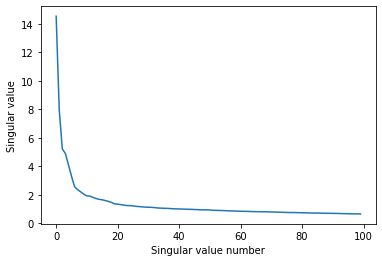

In [26]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [27]:
u, s, v_trans = svds(tfidf_mat, k=20)
v = v_trans.T

In [40]:
df3 = pd.DataFrame.from_dict(song_lyrics, orient='index')

In [37]:
df3.tail()

,0,1,2,3,4,5,6,7,8,9
Iriarte,None,None,None,None,None,None,None,None,None,None
Irmgard Seefried,None,None,None,None,None,None,None,None,None,None
Iron Maiden,"""Iron Maiden"" by Iron Maiden:\n Won't you c...","""My Very Good Favorite Songs From Recommended ...","""Songs Based On Historical Events"" by Genius L...","""My Very Good Favorite Songs From Recommended ...","""October 1990 Album Release Calendar"" by Geniu...","""Reddit AMA"" by PRhyme:\n Royce - can we ex...",None,"""My Very Good Favorite Songs From Recommended ...","""The Value of Psychotic Experience (Part 1 of ...","""What I Listened To In 2015"" by PsyQonaut:\n ..."
Isaiah Rashad,"""Best Songs of 2016 Nominations"" by Genius:\n ...","""4r da Squaw"" by Isaiah Rashad:\n Beat tigh...","""Heavenly Father"" by Isaiah Rashad:\n Yeah\...","""Free Lunch"" by Isaiah Rashad:\n Know it, s...","""Silkk da Shocka"" by Isaiah Rashad:\n Yeah,...","""Smile"" by Isaiah Rashad:\n Yeah, yeah, yea...","""My Review Of “Cilvia Demo” by Isaiah Rashad"" ...","""Stuck in the Mud"" by Isaiah Rashad:\n Part...","""Why Worry"" by Isaiah Rashad:\n Too busy li...","""Tity and Dolla"" by Isaiah Rashad:\n Yeah\n..."
Isao Tomita,None,None,None,None,None,None,None,None,None,None


In [38]:
import json
with open('artist_lyrics_1074-1699.json', 'w') as outfile:
    json.dump(artist_documents, outfile)

In [42]:
df3.to_csv('cs4300sp2021-ag2496-cc972-mb2359-jjz67-jxl8/1074-1699.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'cs4300sp2021-ag2496-cc972-mb2359-jjz67-jxl8/1074-1699.csv'